In [1]:
import os
import sys; sys.path.insert(0, os.path.abspath("../"))
from pathlib import Path
import SimpleITK as sitk
import pandas as pd
import torch
import matplotlib.pyplot as plt
import cv2
import numpy as np

from lungmask import mask
# pip install git+https://github.com/JoHof/lungmask

In [2]:
def convert_nda_to_itk(nda: np.ndarray, itk_image: sitk.Image):
    """From a numpy array, get an itk image object, copying information
    from an existing one. It switches the z-axis from last to first position.

    Args:
        nda (np.ndarray): 3D image array
        itk_image (sitk.Image): Image object to copy info from

    Returns:
        new_itk_image (sitk.Image): New Image object
    """
    new_itk_image = sitk.GetImageFromArray(np.moveaxis(nda, -1, 0))
    new_itk_image.SetOrigin(itk_image.GetOrigin())
    new_itk_image.SetSpacing(itk_image.GetSpacing())
    new_itk_image.CopyInformation(itk_image)
    return new_itk_image

def convert_itk_to_nda(itk_image: sitk.Image):
    """From an itk Image object, get a numpy array. It moves the first z-axis
    to the last position (np.ndarray convention).

    Args:
        itk_image (sitk.Image): Image object to convert

    Returns:
        result (np.ndarray): Converted nda image
    """
    return np.moveaxis(sitk.GetArrayFromImage(itk_image), 0, -1)

(512, 512, 126)
min: 0, max: 4095


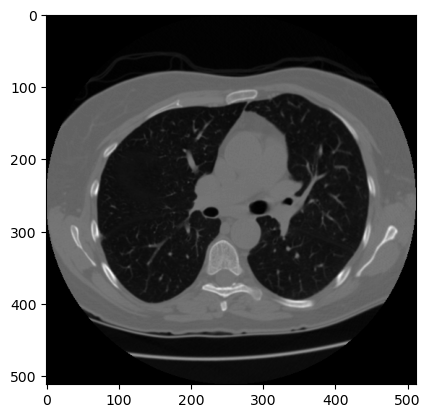

In [55]:
dataset = 'copd'
case = '004'
scan_type = 'insp'
display_slice = 50

img_path = Path().resolve().parent / f"data/{dataset}/scans/case_{case}_{scan_type}.nii.gz"
input_image = sitk.ReadImage(str(img_path))
input_image_nda = convert_itk_to_nda(input_image)

if dataset == 'copd':    
    input_image_nda[input_image_nda == -2000] = 0
    input_image = convert_nda_to_itk(input_image_nda, input_image)

print(input_image.GetSize())
print(f'min: {input_image_nda.min()}, max: {input_image_nda.max()}')
plt.imshow(sitk.GetArrayFromImage(input_image)[display_slice, :, :], cmap='gray')

min: -1024, max: 3071


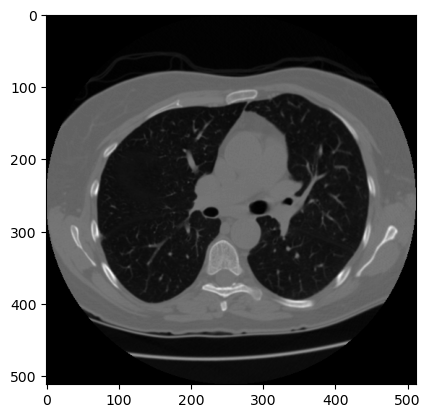

In [56]:
# to HU units
slope = 1
intercept = -1024
image_hu_nda = (input_image_nda * slope) + intercept
print(f'min: {image_hu_nda.min()}, max: {image_hu_nda.max()}')
plt.imshow(image_hu_nda[:, :, display_slice], cmap='gray')

input_image = convert_nda_to_itk(image_hu_nda, input_image)

In [57]:
segmentation = mask.apply(input_image)  # default model is U-net(R231)
print(segmentation.shape)

INFO:root:No GPU support available, will use CPU. Note, that this is significantly slower!


100%|██████████| 2/2 [00:00<00:00, 599.66it/s]


(126, 512, 512)


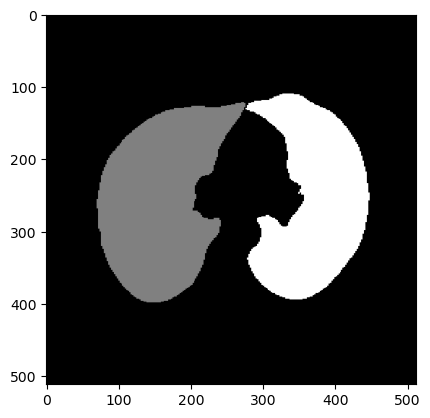

In [58]:
plt.imshow(segmentation[display_slice, :, :], cmap='gray')

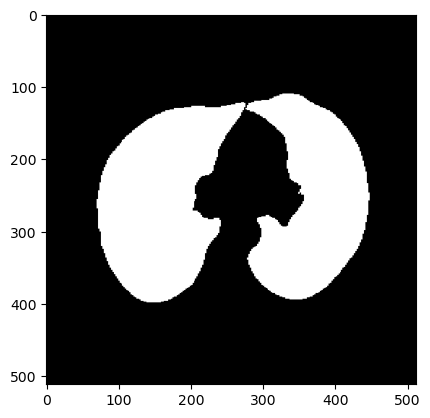

In [59]:
lung_mask = np.moveaxis((segmentation >= 1).astype(np.uint8), 0, -1)
plt.imshow(lung_mask[:, :, display_slice], cmap='gray')

In [60]:
lung_mask_path = img_path.parent.parent / f'lungMasks'
sitk.WriteImage(convert_nda_to_itk(lung_mask, input_image),
                str(lung_mask_path/f'case_{case}_{scan_type}.nii.gz'))